# Clustering explanations of "charge-off" predictions
*by Shayak Sen*

*preprocessing by Vincenzo Pota in August 2017 *

This notebook contains my attempt to predict customers who will charge-off in the future. I describe in detail the following steps:
1. Data Cleaning
2. Feature selection and transformation
3. Define the business case
4. Build the models
5. Test the models

Dataset is given in a flat file and in a database. Let's use the database for good practice and for performances. Once the dataset is better understood, we can perform data cleaning and aggregation in-database to avoid overloading computer memory. 

Let's load the libraries, connect to the database, parse dates and load all data in-memory:

In [1]:
import sqlite3
import pandas as pd 
import numpy as np 
import matplotlib.pylab as plt
%matplotlib inline

conn = sqlite3.connect('database.sqlite') # This might take a while to run...
to_parse = ['issue_d' , 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']
df = pd.read_sql_query('select * from loan', con=conn, parse_dates = to_parse)

The dataframe `df` has 887,384 rows and 75 columns. It occupies 0.5Gb, which might be problematic for later data modelling.

In [2]:
print('The shape is {}'.format(df.shape))
print('Memory : {} Mb'.format(int(df.memory_usage(deep=False).sum() / 1000000)))

The shape is (887383, 75)
Memory : 532 Mb


## Data Cleaning: it is not as bad as it looks

After a closer inspection in Excel, many of the columns seem to contain very little information. I will remove these columns to make the dataset more managable and to release some memory. In a real-case situation, I would not have adopted such a conservative approach.

### Remove columns with more than 60% null values
These are:

In [3]:
check_null = df.isnull().sum(axis=0).sort_values(ascending=False)/float(len(df))
check_null[check_null>0.6]

/home/shayaks/anaconda2/lib/python2.7/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


dti_joint                      0.999426
verification_status_joint      0.999424
annual_inc_joint               0.999424
il_util                        0.979020
mths_since_rcnt_il             0.976549
all_util                       0.975916
max_bal_bc                     0.975916
open_rv_24m                    0.975916
open_rv_12m                    0.975916
total_cu_tl                    0.975916
total_bal_il                   0.975916
open_il_24m                    0.975916
open_il_12m                    0.975916
open_il_6m                     0.975916
open_acc_6m                    0.975916
inq_fi                         0.975916
inq_last_12m                   0.975916
desc                           0.857977
mths_since_last_record         0.845554
mths_since_last_major_derog    0.750160
dtype: float64

...for a total of 21 columns. We can remove these columns with `inplace=True` to overwrite the current dataframe in memory. Remove also a line with all null values...

In [4]:
df.drop(check_null[check_null>0.5].index, axis=1, inplace=True) 
df.dropna(axis=0, thresh=30, inplace=True)

### Remove columns with little information
Here are some columns we want to remove and why:
1. `index` is not needed because it's built-in the dataframe itself
2. `policy_code` is always `== 1`
3. `payment_plan` has only 10 `y` and 887372 `n`
4. `url` not needed, although it might be useful if it contains extra-data (e.g., payment history)
5. `id` and `member_id` are all unique, which is a bit misleading. I was expecting to find payment histories, but it seems that every record is a single customer.
6. `application_type` is 'INDIVIDUAL' for 99.94% of the records
7. `acc_now_delinq` is `0` for 99.5% of the records
8. `emp_title` not needed here, but it might be useful for the modelling (see below), 
9. `zip_code` not needed for this level of analysis,
10. `title` might be useful with NLP, but let's ignore it for now

Numbers above have been calculated by grouping by the metrics, counting the size of each group and sorting. For example:

In [5]:
df.groupby('application_type').size().sort_values()

application_type
JOINT            511
INDIVIDUAL    886871
dtype: int64

We can now delete the columns above:

In [6]:
delete_me = ['index', 'policy_code', 'pymnt_plan', 'url', 'id', 'member_id', 'application_type', 'acc_now_delinq','emp_title', 'zip_code','title']
df.drop(delete_me , axis=1, inplace=True) 

## Feature transformations

The dataset has now 43 columns. We need to transform a few metrics which sound very important, but are formatted as strings. These transformations are performed with the __modelling__ in mind. Ultimatelly we want to produce a dataset almost ready to be fed to the model. Here is a summary of the operations performed:
1. Strip `months` from `term` and make it an integer
2. The Interest rate is a string. Remove `%` and make it a float
3. Extract numbers from `emp_length` and fill missing values with the median (see below). If `emp_length == 10+ years` then leave it as `10`
4. Transform `datetimes` to a Period 

In [7]:
# strip months from 'term' and make it an int
df['term'] = df['term'].str.split(' ').str[1]

#interest rate is a string. Remove % and make it a float
df['int_rate'] = df['int_rate'].str.split('%').str[0]
df['int_rate'] = df.int_rate.astype(float)/100.

# extract numbers from emp_length and fill missing values with the median
df['emp_length'] = df['emp_length'].str.extract('(\d+)').astype(float)
df['emp_length'] = df['emp_length'].fillna(df.emp_length.median())

col_dates = df.dtypes[df.dtypes == 'datetime64[ns]'].index
for d in col_dates:
    df[d] = df[d].dt.to_period('M')

/home/shayaks/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


In [8]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000.0,5000.0,4975.0,36,0.1065,162.87,B,B2,10.0,RENT,...,0.00,0.00,2015-01,171.62,NaT,2016-01,0.0,NaN,NaN,NaN
1,2500.0,2500.0,2500.0,60,0.1527,59.83,C,C4,1.0,RENT,...,117.08,1.11,2013-04,119.66,NaT,2013-09,0.0,NaN,NaN,NaN
2,2400.0,2400.0,2400.0,36,0.1596,84.33,C,C5,10.0,RENT,...,0.00,0.00,2014-06,649.91,NaT,2016-01,0.0,NaN,NaN,NaN
3,10000.0,10000.0,10000.0,36,0.1349,339.31,C,C1,10.0,RENT,...,0.00,0.00,2015-01,357.48,NaT,2015-01,0.0,NaN,NaN,NaN
4,3000.0,3000.0,3000.0,60,0.1269,67.79,B,B5,1.0,RENT,...,0.00,0.00,2016-01,67.79,2016-02,2016-01,0.0,NaN,NaN,NaN


## Data exploration
We now have the data in a more suitable form for data exploration. I could plot different combinations of metrics on 2-dimensional plots and look for interesting trends. Instead, I want to touch briefly two techniques that can allow us to have an overview of the dataset without too much coding involved.

### Use interactive pivot tables with javascript
We can explore the dataset with one single javascript wrapper using the library `pivottablejs` which allows us to do aggregations and plotting using javascipt libraries. On this computer, this library cannot handle 800k rows and 43 columns in a reasonable amount of time, so I decided to input a __random__ selection of 10% of the dataframe. This should be ok for proportions and averaged, but not for absolute counts. This is when aggregating in-database would speed things up.

In [9]:
# pivot_ui(df.sample(frac=0.1))
# opens a new window

A few things to notice:
* A line plot of `issue_dt` vs. `grade` (counted as fraction of columns) reveals that the relative fraction of loan grade changes with time (especially after 2012-07). It would be interesting to understand if this change was due to business changes or to changes in customer behaviour. 
* A stacked bar chart plot of `home_ownership` vs. `loan_status` (counted as fraction of columns) shows that a `loan status` of *Charged_off* is about 4% for customers who own, rent or with a mortgage. Even though the `loan_status` is 10% and 25% for customers with None or Other, the total counts for these categories are very small. 
* A stacked bar chart plot of `grade` vs. `loan_status` (counted as fraction of columns) shows that, as expected, the *Charged_off* status becomes more and more relevant for higher interest rates (grades F and G)

# Data Modelling

__Let's build a model which predicts the status *charged_off*__. The fraction of this status in the whole dataset is low, only around 5%, but not as low as other status. 

In [10]:
loan_status_grouped = df.groupby('loan_status').size().sort_values(ascending=False)/len(df) * 100
loan_status_grouped

loan_status
Current                                                67.815326
Fully Paid                                             23.408633
Charged Off                                             5.099044
Late (31-120 days)                                      1.306202
Issued                                                  0.953366
In Grace Period                                         0.704657
Late (16-30 days)                                       0.265613
Does not meet the credit policy. Status:Fully Paid      0.224030
Default                                                 0.137370
Does not meet the credit policy. Status:Charged Off     0.085758
dtype: float64

This is indeed a bit problematic, but let's how the models perform first.

## The business problem
In developing the model we need to think about the business problem we are trying to solve. I have identified two different scenarios:
1. In the first scenario, the investor (assuming he/she has access to our same data) wants to predict the risk of *charged off* before lending the money to a borrower. The metrics associated to activity in the Loan Club are not known because the customer is still a prospect borrower.
2. In the second scenario, Loan Club wants to predict probability for a borrower to charge off while he/she is "Current", maybe to prevent the charge off from happening or try to minimise damage.

I do not fully understand the meaning of all metrics. Therefore I will adopt the first scenario because I believe is the one which makes more sense with my current understanding of the problem. 

The problem therefore becomes: __How well can we predict that a prospect customer will charge off at some point in the future?__ 

## More feature engeneering
We can finally choose the metrics for the model remembering to check for missing values and transforming metrics in a way suitable for modelling. 

* Let's keep the `loan_amount`, but let's create a metric which indicates that the total amount committed by investors for that loan at that point in time (`funded_amnt_inv`) is less than what the borrower requested.

In [11]:
df['amt_difference'] = 'eq'
df.loc[(df['funded_amnt'] - df['funded_amnt_inv']) > 0,'amt_difference'] = 'less'

* The interest rate is an important metrics, but it changes with time, whereas the interest grade does not. So, we will consider the interest `grade` only, exluding the `sub_grade` to keep it simple.

* the metrics `delinq_2yrs` is very skewed towards zero (80% are zeros). Let's make it categorical: `no` when `delinq_2yrs == 0` and `yes` when  `delinq_2yrs > 0`

* Same as above for `inq_last_6mths`: The number of inquiries in past 6 months (excluding auto and mortgage inquiries)

* Same as above for `pub_rec`: Number of derogatory public records

* I thought about computing difference between the date of the earliest credit line and the issue date `df['tmp'] = df.earliest_cr_line - df.issue_d`, but I do not understand the metrics well, so I will skip this

* Let's compute the ratio of the number of open credit lines in the borrower's credit file divided by the total number of credit lines currently in the borrower's credit file

In [12]:
# Make categorical

df['delinq_2yrs_cat'] = 'no'
df.loc[df['delinq_2yrs']> 0,'delinq_2yrs_cat'] = 'yes'

df['inq_last_6mths_cat'] = 'no'
df.loc[df['inq_last_6mths']> 0,'inq_last_6mths_cat'] = 'yes'

df['pub_rec_cat'] = 'no'
df.loc[df['pub_rec']> 0,'pub_rec_cat'] = 'yes'

# Create new metric
df['acc_ratio'] = df.open_acc / df.total_acc

These are the features we want to model

In [13]:
features = ['loan_amnt', 'amt_difference', 'term', 
            'installment', 'grade','emp_length',
            'home_ownership', 'annual_inc','verification_status',
            'purpose', 'dti', 'delinq_2yrs_cat', 'inq_last_6mths_cat', 
            'open_acc', 'pub_rec', 'pub_rec_cat', 'acc_ratio', 'initial_list_status',  
            'loan_status'
           ]

Given the business problem stated above, we want to distinguish between a customer who will *charge off* and a customer who will pay in full. I will not model the cohort of *Current* customers because these are still "in progress" and belong to the second scenario. 

In [14]:
X_clean = df.loc[df.loan_status != 'Current', features]
X_clean.head()

,loan_amnt,amt_difference,term,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs_cat,inq_last_6mths_cat,open_acc,pub_rec,pub_rec_cat,acc_ratio,initial_list_status,loan_status
0,5000.0,less,36,162.87,B,10.0,RENT,24000.0,Verified,credit_card,27.65,no,yes,3.0,0.0,no,0.333333,f,Fully Paid
1,2500.0,eq,60,59.83,C,1.0,RENT,30000.0,Source Verified,car,1.00,no,yes,3.0,0.0,no,0.750000,f,Charged Off
2,2400.0,eq,36,84.33,C,10.0,RENT,12252.0,Not Verified,small_business,8.72,no,yes,2.0,0.0,no,0.200000,f,Fully Paid
3,10000.0,eq,36,339.31,C,10.0,RENT,49200.0,Source Verified,other,20.00,no,yes,10.0,0.0,no,0.270270,f,Fully Paid
5,5000.0,eq,36,156.46,A,3.0,RENT,36000.0,Source Verified,wedding,11.20,no,yes,9.0,0.0,no,0.750000,f,Fully Paid


In [15]:
mask = (X_clean.loan_status == 'Charged Off')
X_clean['target'] = 0
X_clean.loc[mask,'target'] = 1

## A few last touches
We need to transform categorical variables in continuous variables using the One Hot Encoder. `pandas` has a built-in function for this.

In [16]:
cat_features = ['term','amt_difference', 'grade', 'home_ownership', 'verification_status', 'purpose', 'delinq_2yrs_cat', 'inq_last_6mths_cat', 'pub_rec_cat', 'initial_list_status']

# Drop any residual missing value (only 24)
X_clean.dropna(axis=0, how = 'any', inplace = True)

X = pd.get_dummies(X_clean[X_clean.columns[:-2]], columns=cat_features).astype(float)
y = X_clean['target']

In [17]:
X.shape

(285572, 50)

## The models

Let's start modelling by importing a few modules. Features are all on different scale, so it is wise to rescale all features in the range -1, +1

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE

X_scaled = preprocessing.scale(X)
print(X_scaled)
print('   ')
print(X_scaled.shape)

[[-1.06342482 -1.05092656  1.19312049 ..., -0.38225728  0.67045937
  -0.67045937]
 [-1.36792459 -1.46919029 -1.43222345 ..., -0.38225728  0.67045937
  -0.67045937]
 [-1.38010458 -1.369739    1.19312049 ..., -0.38225728  0.67045937
  -0.67045937]
 ..., 
 [-0.91421993 -0.81752047 -1.14051857 ..., -0.38225728  0.67045937
  -0.67045937]
 [-1.18522473 -1.19819566  1.19312049 ...,  2.61603913  0.67045937
  -0.67045937]
 [-0.35089537 -0.09225668  0.02630096 ..., -0.38225728  0.67045937
  -0.67045937]]
   
(285572, 50)


/home/shayaks/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Write a function that :
1. Takes train and test set under different assumptions
2. Runs a set of models. 3 in this case: Gradient Boosting, Logistic Regression and Random Forest
3. Makes prediction using the test set
4. Builds-up a table with evaluation metrics
5. Plots a roc curve of the estimators

In [19]:
from xgboost import XGBClassifier
def run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced'):
    
    #clfs = {'GradientBoosting': GradientBoostingClassifier(max_depth= 4, n_estimators=100, max_features = 0.3),
    #        'LogisticRegression' : LogisticRegression(),
    #        #'GaussianNB': GaussianNB(),
    #        'RandomForestClassifier': RandomForestClassifier(n_estimators=50),
    #        'XG Boost': XGBClassifier()
    #        }
    clfs = {#'GradientBoosting': GradientBoostingClassifier(max_depth= 4, n_estimators=100, max_features = 0.3),
            'LogisticRegression' : LogisticRegression(),
            #'GaussianNB': GaussianNB(),
            #'RandomForestClassifier': RandomForestClassifier(n_estimators=50),
            'XG Boost': XGBClassifier(),
            #'XG Boost 1': XGBClassifier(subsample=0.5, objective='binary:logistic'),
            #'XG Boost 2': XGBClassifier(n_estimators=50, objective='binary:logistic'),
            #'XG Boost 3': XGBClassifier(subsample=0.5, n_estimators=50, objective='binary:logistic'),
            #'XG Boost 4': XGBClassifier(subsample=0.4, n_estimators=75, objective='binary:logistic'),
            #'XG Boost 5': XGBClassifier(subsample=0.5, n_estimators=50, min_child_weight=3, objective='binary:logistic'),
            #'XG Boost 6': XGBClassifier(subsample=0.4, n_estimators=75, min_child_weight=5, objective='binary:logistic'),
            #'XG Boost 7': XGBClassifier(subsample=0.5, n_estimators=50, min_child_weight=3, max_depth=5, objective='binary:logistic'),
            #'XG Boost 8': XGBClassifier(subsample=0.4, n_estimators=75, min_child_weight=5, max_depth=7, objective='binary:logistic'),
            #'XG Boost 9': XGBClassifier(subsample=0.4, n_estimators=75, min_child_weight=5, max_depth=7, objective='binary:logistic')
           }
            
    cols = ['model','matthews_corrcoef', 'roc_auc_score', 'precision_score', 'recall_score','f1_score']

    models_report = pd.DataFrame(columns = cols)
    models_report_train = pd.DataFrame(columns = cols)
    conf_matrix = dict()

    for clf, clf_name in zip(clfs.values(), clfs.keys()):

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        y_score = clf.predict_proba(X_test)[:,1]
        
        y_pred_train = clf.predict(X_train)
        y_score_train = clf.predict_proba(X_train)[:,1]


        print('computing {} - {} '.format(clf_name, model_type))

        tmp_test = pd.Series({'model_type': model_type,
                         'model': clf_name,
                         'roc_auc_score' : metrics.roc_auc_score(y_test, y_score),
                         'matthews_corrcoef': metrics.matthews_corrcoef(y_test, y_pred),
                         'precision_score': metrics.precision_score(y_test, y_pred),
                         'recall_score': metrics.recall_score(y_test, y_pred),
                         'f1_score': metrics.f1_score(y_test, y_pred)})
        tmp_train = pd.Series({'model_type': model_type,
                         'model': clf_name,
                         'roc_auc_score' : metrics.roc_auc_score(y_train, y_score_train),
                         'matthews_corrcoef': metrics.matthews_corrcoef(y_train, y_pred_train),
                         'precision_score': metrics.precision_score(y_train, y_pred_train),
                         'recall_score': metrics.recall_score(y_train, y_pred_train),
                         'f1_score': metrics.f1_score(y_train, y_pred_train)})

        models_report = models_report.append(tmp_test, ignore_index = True)
        models_report_train =  models_report_train.append(tmp_train, ignore_index = True)
        conf_matrix[clf_name] = pd.crosstab(y_test, y_pred, rownames=['True'], colnames= ['Predicted'], margins=False)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, drop_intermediate = False, pos_label = 1)

        plt.figure(1, figsize=(6,6))
        plt.xlabel('false positive rate')
        plt.ylabel('true positive rate')
        plt.title('ROC curve - {}'.format(model_type))
        plt.plot(fpr, tpr, label = clf_name )
        plt.legend(loc=2, prop={'size':11})
    plt.plot([0,1],[0,1], color = 'black')
    
    return {'test' : models_report, 'train': models_report_train} , conf_matrix, clfs

### Model with unbalanced classes
If we do not modify the class ratios our model has very poor predictive power. The area ander the curve (AUC) is about 0.6, suggesting that we perform better than random. However, the recall is zero: we cannot predict the target variable at all. This might be either because there is something wrong with the metrics or because the classes are too unbalanced. 

computing LogisticRegression - Non-balanced 
computing XG Boost - Non-balanced 


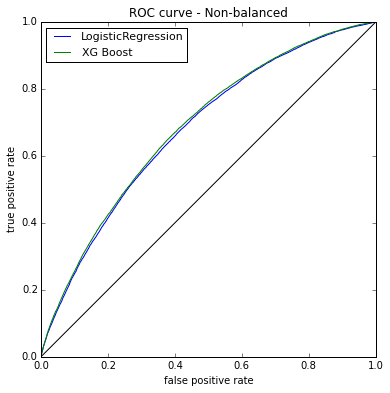

In [20]:
#mpl.rc("savefig", dpi=300)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y.values, test_size=0.4, random_state=0)
models_report, conf_matrix, clfs = run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced')

In [21]:
models_report['train']

,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,model_type
0,LogisticRegression,0.011838,0.676549,0.378788,0.000920,0.001836,Non-balanced
1,XG Boost,0.014565,0.688833,0.769231,0.000368,0.000736,Non-balanced


In [22]:
models_report['test']

,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,model_type
0,LogisticRegression,0.022505,0.678667,0.516667,0.001714,0.003417,Non-balanced
1,XG Boost,0.012362,0.684503,0.666667,0.000332,0.000663,Non-balanced


In [23]:
conf_matrix['LogisticRegression']

Predicted,0,1
True,,
0,96116,29
1,18053,31


### Model with synthetically balanced classes

We can artificially balance the classes using the algorithm SMOTE ( Synthetic Minority Over-sampling Technique). This uses a K-nearest neighbour approach to create feature vectors which resemble those of the target variable. The minority class is oversampled. With this trick, the performance of the model improves considerably.

We now have a recall of 70% using Logistic Regression. We get right 7 out of 10 customers who will "charge off". On the other hand we have a precision of 20%. 

computing LogisticRegression - Balanced 
computing XG Boost - Balanced 


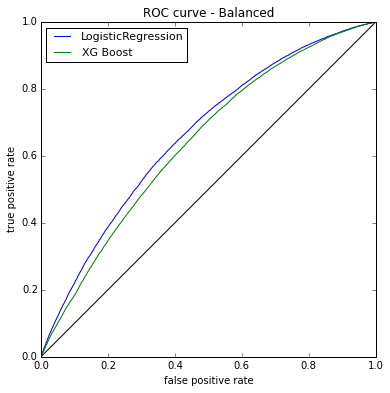

In [24]:
index_split = int(len(X)/2)
X_train, y_train = SMOTE().fit_sample(X_scaled[0:index_split, :], y[0:index_split])
X_test, y_test = X_scaled[index_split:], y[index_split:]

#scores = cross_val_score(clf, X_scaled, y , cv=5, scoring='roc_auc')

models_report_bal, conf_matrix_bal, clfs_bal = run_models(X_train, y_train, X_test, y_test, model_type = 'Balanced')

In [25]:
models_report_bal['train']

,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,model_type
0,LogisticRegression,0.285987,0.695469,0.637246,0.663375,0.650048,Balanced
1,XG Boost,0.704486,0.914014,0.909630,0.773370,0.835984,Balanced


In [26]:
models_report_bal['test']

,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,model_type
0,LogisticRegression,0.165236,0.661723,0.200925,0.710059,0.313219,Balanced
1,XG Boost,0.103751,0.639697,0.235466,0.223515,0.229335,Balanced


In [27]:
conf_matrix_bal['LogisticRegression']

Predicted,0,1
True,,
0,64209,58028
1,5958,14591


In [28]:
conf_matrix_bal['XG Boost']

Predicted,0,1
True,,
0,107324,14913
1,15956,4593


In [29]:
X_test[0,:]

array([ -1.06342482e+00,  -1.06756943e+00,  -5.57108806e-01,
        -1.25812280e-01,  -9.54479748e-01,  -4.07631208e-01,
        -3.31659971e-01,   1.08230540e-01,   5.55399646e-01,
        -5.55399646e-01,   4.53859342e-01,  -4.53859342e-01,
         2.31615466e+00,  -6.38960837e-01,  -5.95070148e-01,
        -4.47003105e-01,  -3.00441207e-01,  -1.85068155e-01,
        -9.54075582e-02,  -1.87129798e-03,  -9.79205691e-01,
        -1.24137212e-02,  -2.50440670e-02,  -3.12650098e-01,
         1.17351268e+00,   1.41275144e+00,  -6.55643932e-01,
        -7.59092804e-01,  -1.18065593e-01,   2.01695213e+00,
        -1.19516356e+00,  -3.84697654e-02,  -2.50400185e-01,
        -8.08152832e-02,  -1.58158427e-01,  -1.06723365e-01,
        -8.99694027e-02,  -2.45707411e-01,  -3.20478507e-02,
        -1.38265915e-01,  -7.94207699e-02,  -8.44453519e-02,
         4.49977004e-01,  -4.49977004e-01,  -9.77937214e-01,
         9.77937214e-01,   3.82257279e-01,  -3.82257279e-01,
         6.70459369e-01,

# Clustering with respect to  QIIs
We first compute the QIIs for 2000 points for scoring outputs
Score outputs are computed as the log loss of the probabilities

In [111]:
import qii_lite
import pandas
use_stored = True
clf = clfs_bal['XG Boost']
if (use_stored):
    shapleys_df = pandas.read_csv('shapleys_1141_scores_xgboost.csv', index_col=0)
    X_test = np.array(pandas.read_csv('test_1141_scores_xgboost.csv', index_col=0))
    raw_data = pandas.read_csv('rawdata_1141_scores_xgboost.csv', index_col=0)
else:
    clf = clfs_bal['XG Boost']
    shapleys_all = {}
    for i in xrange(2000):
        shapleys_all[i] = qii_lite.shapley_influence_score(clf, np.array([X_test[i]]), X_test, features)
    shapleys_df = pd.DataFrame.from_dict(shapleys_all, orient='index')
    

In [85]:
X_test

array([[-1.06342482, -1.06756943, -0.55710881, ..., -0.38225728,
         0.67045937, -0.67045937],
       [ 0.40426405, -0.01829739,  0.90141561, ..., -0.38225728,
         0.67045937, -0.67045937],
       [-1.02688485, -0.97327337,  1.19312049, ..., -0.38225728,
         0.67045937, -0.67045937],
       ..., 
       [-0.94162491, -0.87857138,  0.90141561, ..., -0.38225728,
         0.67045937, -0.67045937],
       [ 0.76357378,  0.81778355, -1.43222345, ..., -0.38225728,
         0.67045937, -0.67045937],
       [ 0.25810417,  0.64798569,  0.31800584, ..., -0.38225728,
         0.67045937, -0.67045937]])

## Try out a few clustering algorithms
KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN

In [86]:
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN
#model = KMeans(3)
model1 = AgglomerativeClustering(affinity = 'euclidean', linkage = 'ward')
clust_labels1 = model1.fit_predict(shapleys_df)

In [87]:
clust_labels1.max()

1

In [88]:
model2 = AffinityPropagation(damping = 0.5, max_iter = 250, affinity = 'euclidean')
clust_labels2 = model2.fit_predict(shapleys_df)

In [89]:
clust_labels2.max()

55

In [90]:
model3 = KMeans(5)
clust_labels3 = model3.fit_predict(shapleys_df)

In [91]:
clust_labels3.max()

4

In [92]:
from sklearn.cluster import DBSCAN
model4 = DBSCAN(eps=0.25, min_samples=5)
clust_labels4 = model4.fit_predict(shapleys_df)

DBSCAN learns its own clusters, and found 4 clusters. Let's go with that

In [93]:
clust_labels4.max()
clust_labels=clust_labels4

In [94]:
[(clust_labels4 == i).sum() for i in range(-1,clust_labels4.max()+1)]

[53, 202, 123, 424, 332, 7]

## Try learning a decision tree on the cluster

In [99]:
from sklearn import tree
explainer = tree.DecisionTreeClassifier(max_leaf_nodes=8)
explainer.fit(shapleys_df, clust_labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=8, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

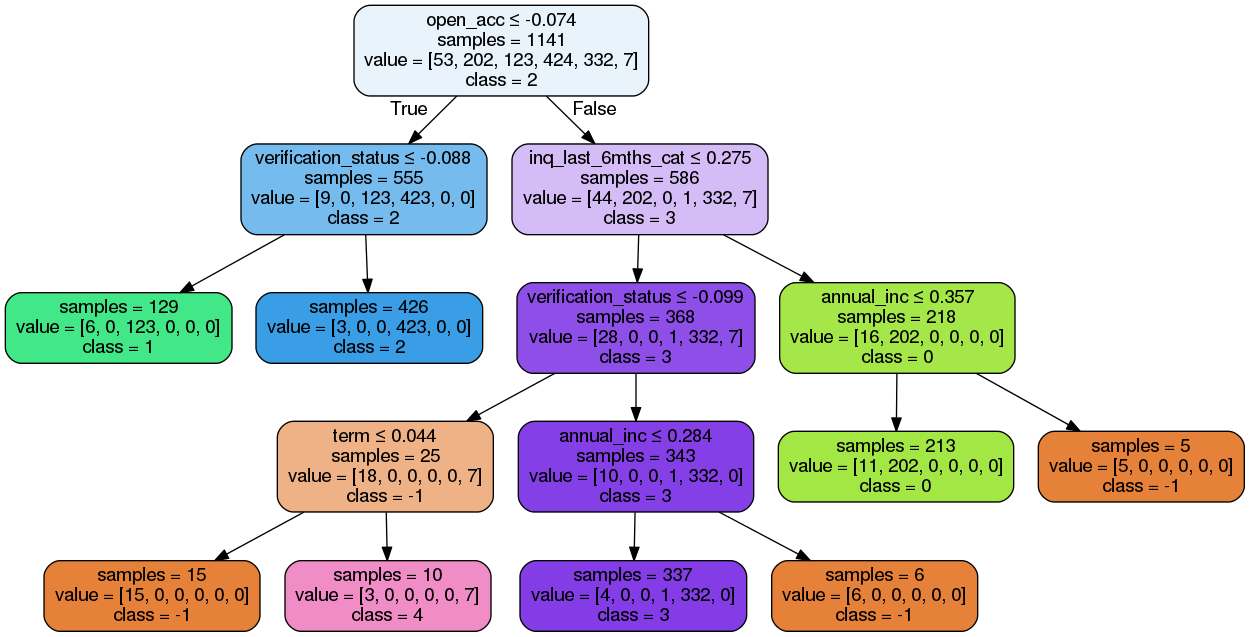

In [100]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(explainer, out_file=dot_data,
                feature_names=list(shapleys_df),
                filled=True, rounded=True, impurity=False,
                special_characters=True, class_names=['-1','0','1','2','3','4'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [101]:
from sklearn import tree
mapper = tree.DecisionTreeClassifier(max_leaf_nodes=8)
mapper.fit(np.array(X_test)[0:1141,:], clust_labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=8, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

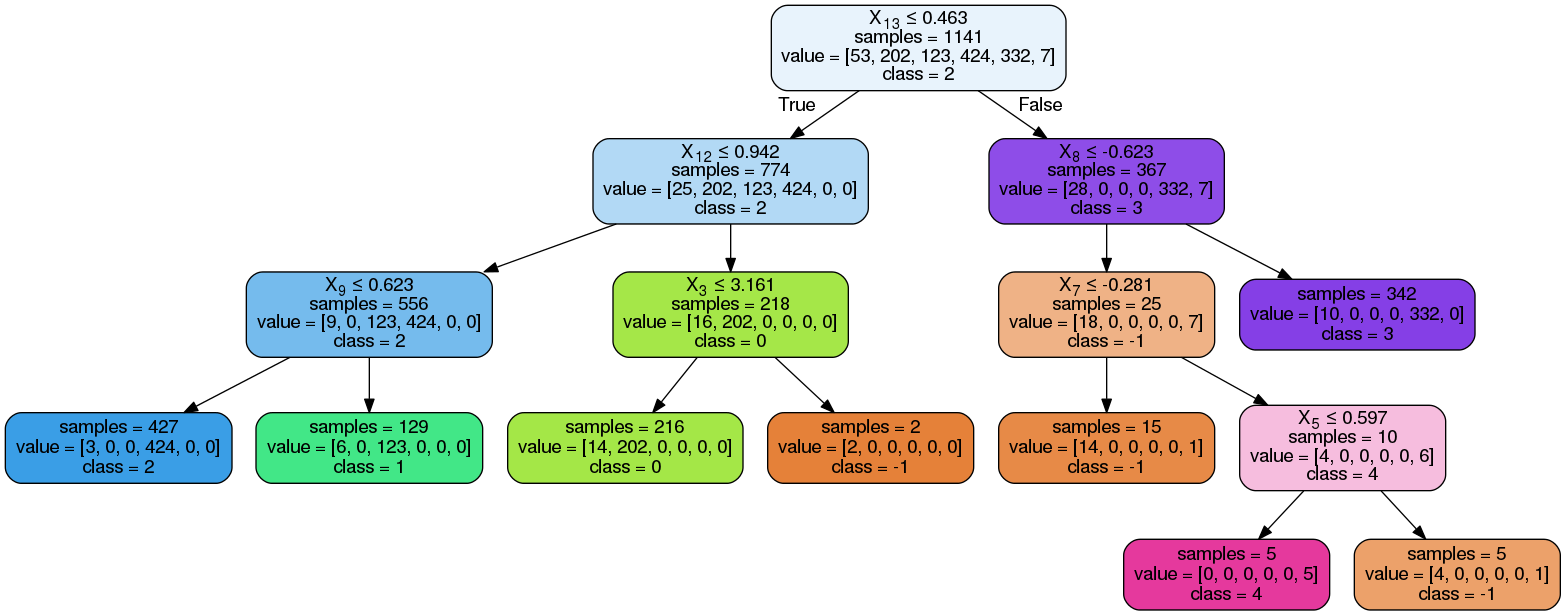

In [102]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(mapper, out_file=dot_data,  
                filled=True, rounded=True, impurity=False,
                special_characters=True,
                #feature_names=list(X.columns), 
                class_names=['-1','0','1','2','3','4'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [103]:
X.columns[[13,12,8, 3, 8, 7]]

Index([u'grade_B', u'grade_A', u'term_36', u'annual_inc', u'term_36',
       u'acc_ratio'],
      dtype='object')

In [105]:
real_indices = [np.argmax((X_scaled == X_test[i]).sum(axis=1)) for i in range(0, 1141)]

In [106]:
raw_data = X_clean.iloc[real_indices]

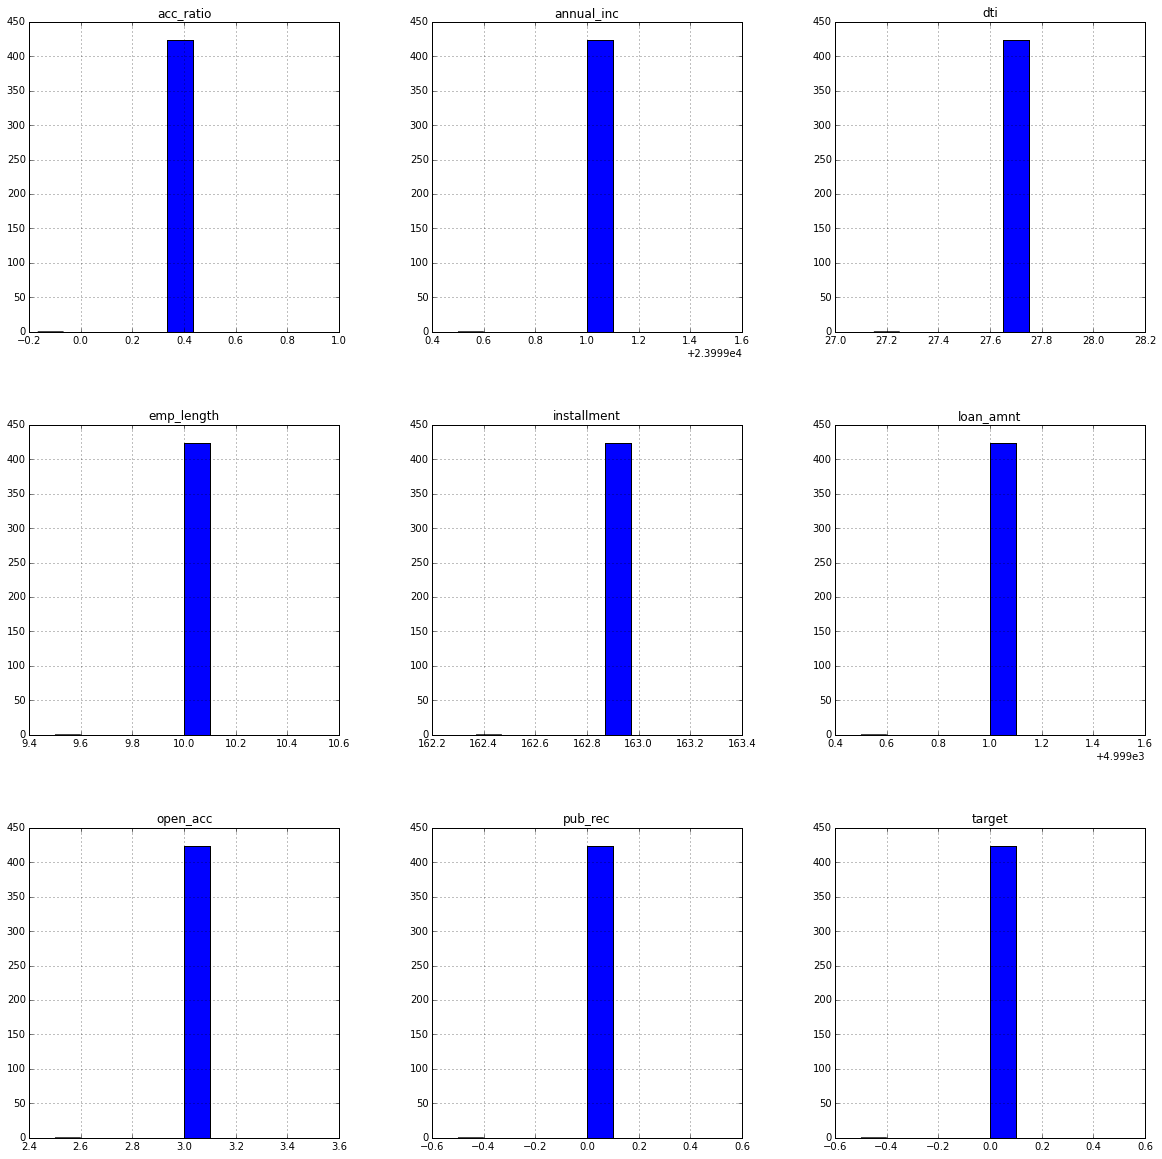

In [107]:
raw_data_class2 = raw_data[clust_labels == 2]
raw_data_class2.hist(figsize=(20,20))
plt.show()

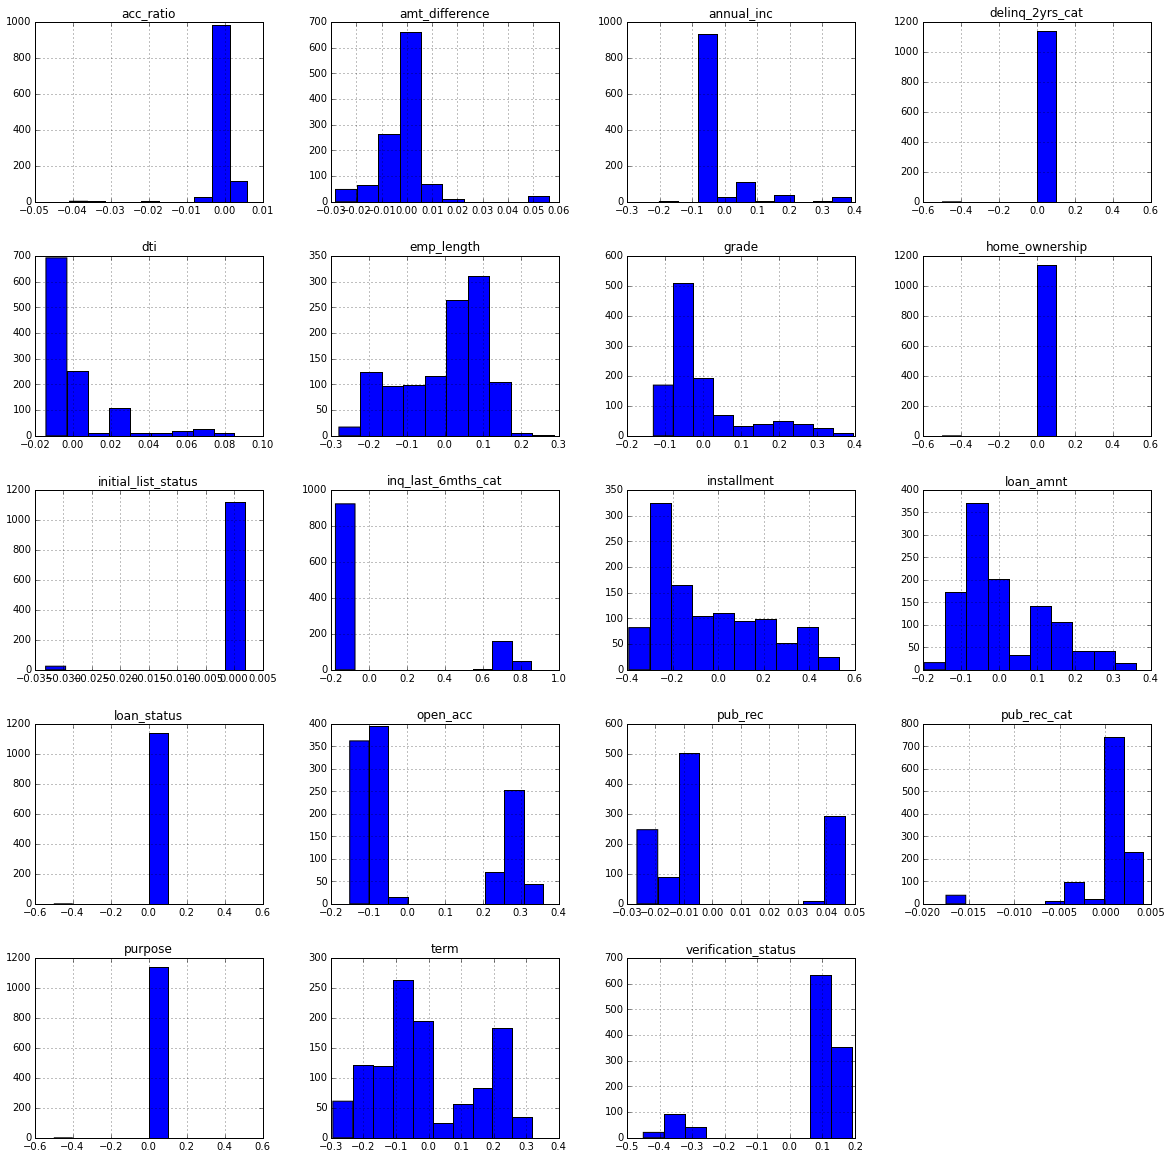

In [108]:
shapleys_df.hist(figsize=(20,20))
plt.show()

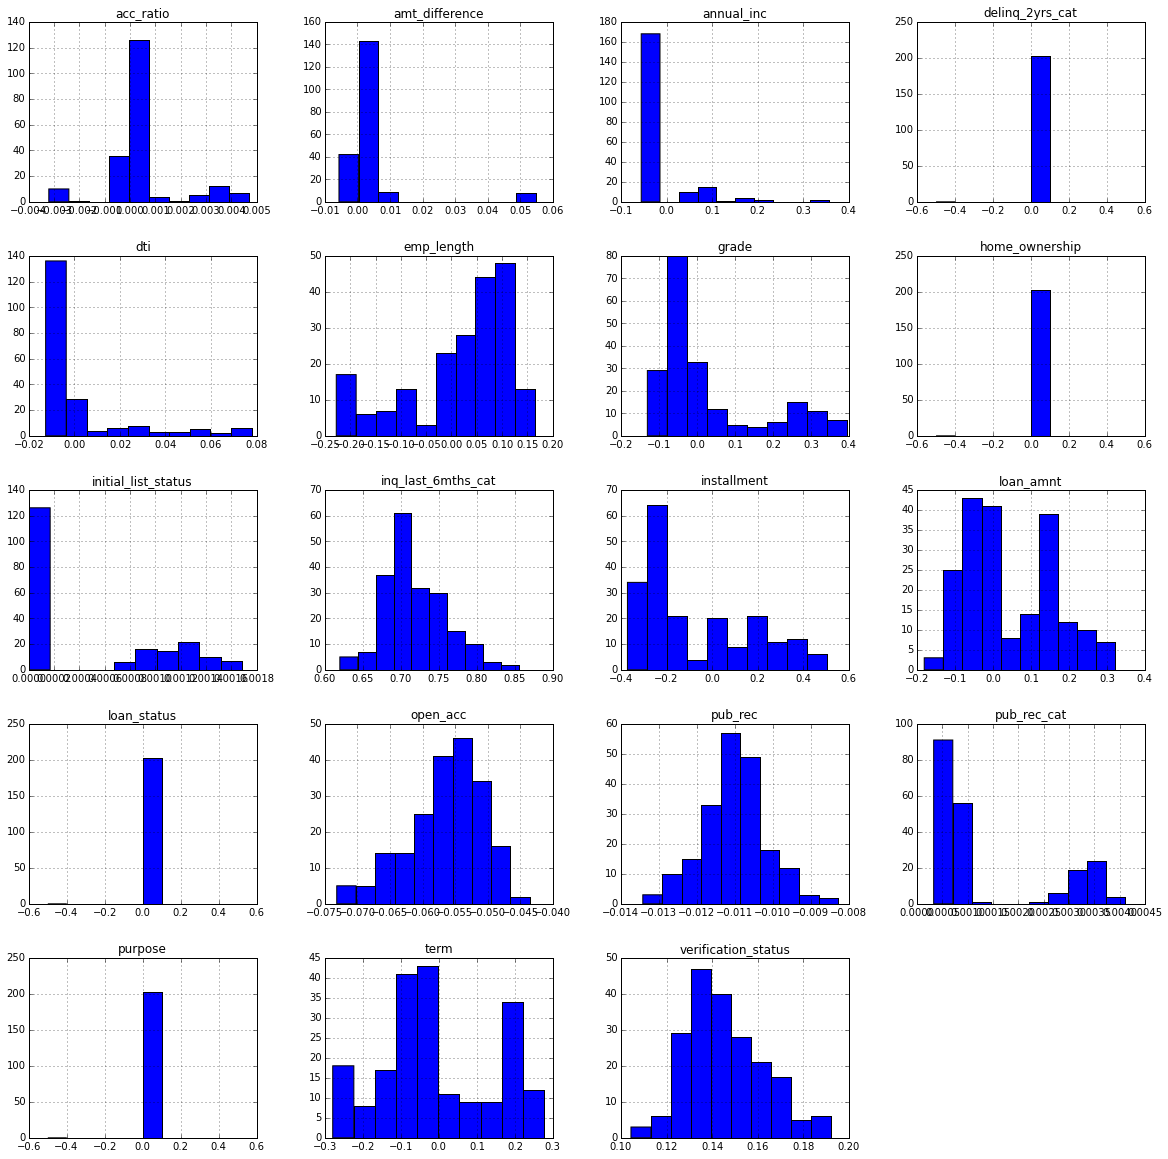

In [109]:
shapleys_df[clust_labels == 0].hist(figsize=(20,20))
plt.show()

## Plot score histograms for clusters

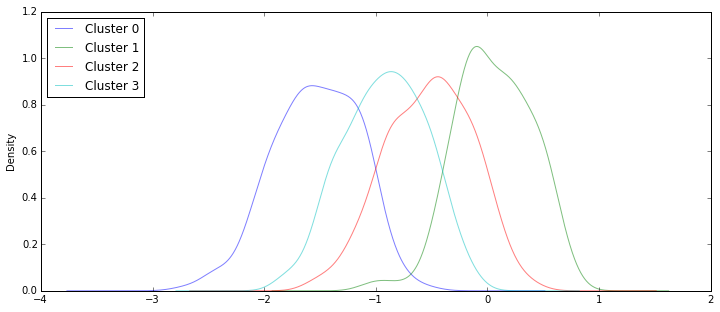

In [112]:
import scipy.special as special
X_test_1141 = X_test[0:1141,:]
for i in xrange(0, 4):
    score_series_i = pd.Series(special.logit(clf.predict_proba(X_test_1141[clust_labels4 == i])[:,1]))
    score_series_i.plot(kind='kde',figsize=(12,5), alpha=0.5, label='Cluster '+str(i))
plt.legend(loc='upper left')
plt.show()